### Warning
This file contains in progress work on the model and may have weird bugs I haven't worked out yet.

In [1]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /home/nels/.cache/torch/hub/pytorch_vision_v0.10.0
/home/nels/TeamVida/tick-classification/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nels/TeamVida/tick-classification/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
class VegetationDataset(Dataset):
    def __init__(self, image_path, mask_path, tranform=None):
        """Simple dataset for vegetation segmentation test."""
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = tranform
    
    def __len__(self):
        return 1
    
    def __rgb_to_class_mask(self, rgb_mask):
        """Convert the RGB mask to grayscale class mask."""
        height, width = rgb_mask.shape[:2]
        class_mask = np.zeros((height, width), dtype=np.uint8)

        # Black background
        black_mask  = (rgb_mask[:, :, 0] == 0) & (rgb_mask[:, :, 1] == 0) & (rgb_mask[:, :, 2] == 0)
        class_mask[black_mask] = 0

        # Green vegetation
        green_mask = (rgb_mask[:, :, 0] == 0) & (rgb_mask[:, :, 1] > 0) & (rgb_mask[:, :, 2] == 0)
        class_mask[green_mask] = 1

        # Blue vegetation
        blue_mask = (rgb_mask[:, :, 2] > rgb_mask[:,:,0]) & ((rgb_mask[:, :, 2])  > (rgb_mask[:, :, 1]))
        class_mask[blue_mask] = 2

        return class_mask
    
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_path).convert('RGB')


        mask = Image.open(self.mask_path).convert('RGB')
        mask = np.array(mask)
        mask = self.__rgb_to_class_mask(mask)

        if self.transform:
            image = self.transform(image)
        
        # Mask to tensor
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [8]:
def create_deeplabv3_model(num_classes=3):
    """Create a modified DeepLabV3 model for vegetation segmentation."""
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    return model


In [ ]:
def create_deeplabv3_model(num_classes=3):
    """create model with pretrained resnet101 backbone."""
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)

    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    return model

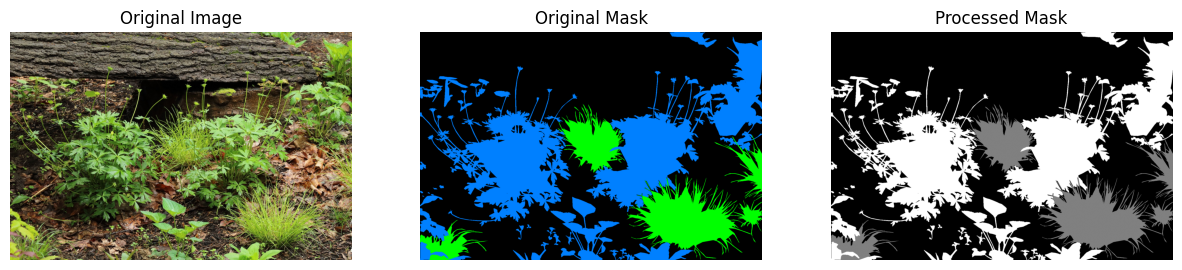

In [5]:
def show_dataset_sample(dataset, idx = 0):
    image_raw = Image.open(dataset.image_path).convert('RGB')
    mask_raw = Image.open(dataset.mask_path).convert('RGB')

    image, mask = dataset[idx]

    fig,axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_raw)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask_raw)
    axes[1].set_title('Original Mask')
    axes[1].axis('off')
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('Processed Mask')
    axes[2].axis('off')
    plt.show()

Image_path = 'TestImage.jpg'
Mask_path = 'TestImageMask.png'
dataset = VegetationDataset(image_path=Image_path, mask_path=Mask_path, tranform=None)
show_dataset_sample(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1975338].


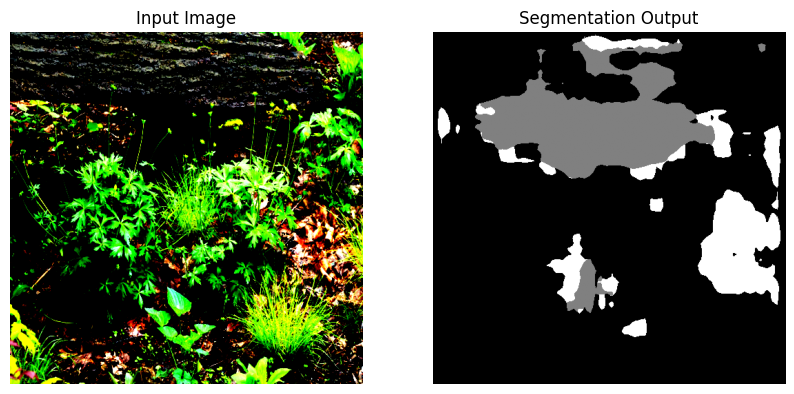

Pipeline test completed successfully.


In [ ]:
def test_pipeline():
    """Test the segmentation pipeline."""
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    IMAGE_PATH = 'TestImage.jpg'
    MASK_PATH = 'TestImageMask.png'
    dataset = VegetationDataset(image_path=IMAGE_PATH, mask_path=MASK_PATH, tranform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    model = create_deeplabv3_model(num_classes=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            masks = masks.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            outputs = model(images)['out']
            outputs = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

            # Display the results
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(outputs, cmap='gray')
            plt.title('Segmentation Output')
            plt.axis('off')

            plt.show()
            break 


if __name__ == "__main__":
    test_pipeline()
    print("Pipeline test completed successfully.") 